In [110]:
import hmclab
import matplotlib.pyplot as plt

# Tutorial 5 - Transforming existing distributions

In this notebook we will show how to use a coordinate transform on any distribution. We define a Normal distribution in logarithmic space by simply initializing a Normal distribution and transforming it to logarithmic coordinates. The transformation described in this notebook can in principle be applied to any distribution. 

In [215]:
dimensions = 10
ones = numpy.ones((dimensions,1))

prior_1 = hmclab.Distributions.Normal(
    means=3 * ones,
    covariance=[0.05]*100,
)
prior_1_l = hmclab.Distributions.TransformToLogSpace(prior_1)

Let's generate samples from both distributions, as well as transforming the samples from the original distribution, to illustrate exactly what is happening. The samples from the transformed distribution and the transformed samples of the original distribution should be the same.

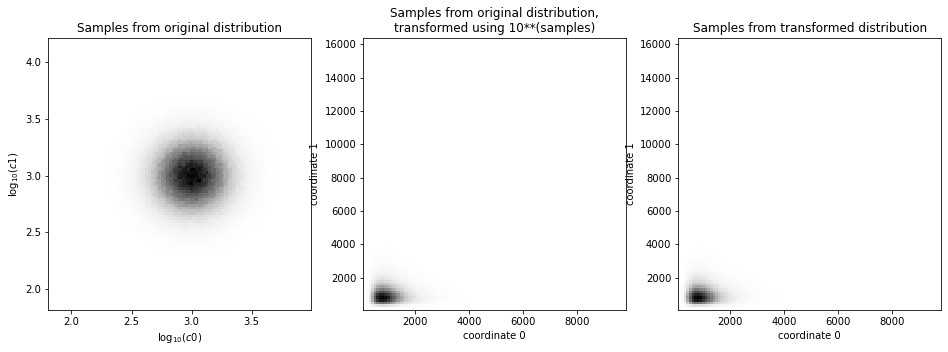

In [216]:
n_samples = 1000000

plt.figure(figsize=(16,5))

plt.subplot(131)
plt.title("Samples from original distribution")
samples = prior_1.generate(n_samples)
plt.hist2d(samples[0, :], samples[1, :], bins=100, cmap=plt.get_cmap("Greys"))
plt.xlabel("$\log_{10}(c0)$")
plt.ylabel("$\log_{10}(c1)$")

plt.subplot(132)
plt.title("Samples from original distribution,\ntransformed using 10**(samples)")
samples = 10**samples
_, bins1, bins2, _ = plt.hist2d(samples[0, :], samples[1, :], bins=100, cmap=plt.get_cmap("Greys"))
plt.xlabel("coordinate 0")
plt.ylabel("coordinate 1")

plt.subplot(133)
plt.title("Samples from transformed distribution")
samples = prior_1_l.generate(n_samples)
_ = plt.hist2d(samples[0, :], samples[1, :], bins=[bins1,bins2], cmap=plt.get_cmap("Greys"))
plt.xlabel("coordinate 0")
plt.ylabel("coordinate 1");

That looks like some good agreement! Let's test if this transformation also works with gradient based and standard Random Walk sampling, applying both HMC and RWMH:

In [236]:
initial_model = prior_1_l.generate()
import numpy
initial_model = 400.0 * numpy.ones((100,1))

sampler_rwmh = hmclab.Samplers.RWMH()

sampler_rwmh.sample(
    "bin_samples/tutorial_5_rwmh.h5",
    prior_1_l,
    stepsize=1.0,
    initial_model=initial_model,
    overwrite_existing_file=True,
    online_thinning=1,
    autotuning=True,
    proposals=100000,
    max_time=1.0,
)

sampler_hmc = hmclab.Samplers.HMC()

_ = sampler_hmc.sample(
    "bin_samples/tutorial_5_hmc.h5",
    prior_1_l,
    stepsize=10.0,
    initial_model=initial_model,
    overwrite_existing_file=True,
    online_thinning=1,
    amount_of_steps=10,
    autotuning=True,
    proposals=20000,
    max_time=1.0,
)

sampler_hmc_many_samples = hmclab.Samplers.HMC()

_ = sampler_hmc_many_samples.sample(
    "bin_samples/tutorial_5_hmc_many_samples.h5",
    prior_1_l,
    stepsize=1.0,
    initial_model=initial_model,
    overwrite_existing_file=True,
    online_thinning=1,
    amount_of_steps=10,
    autotuning=True,
    proposals=100000,
    max_time=10.0,
    disable_progressbar=True,
)

sampler_rwmh._repr_html_(), sampler_hmc._repr_html_()

Tot. acc rate: 0.87. Progress:   1%|          | 1156/100000 [00:01<01:25, 1152.75it/s]


Tot. acc rate: 0.46. Progress:   1%|          | 134/20000 [00:01<02:28, 133.55it/s]

('', '')

In [237]:
samples_rwmh = sampler_rwmh.load_results()
samples_hmc = sampler_hmc.load_results()
samples_hmc_many_samples = sampler_hmc_many_samples.load_results()

Let's visualize the result of this sampling. To quantify the extremes, we'll make the vertical scale of the histograms logarithmic.

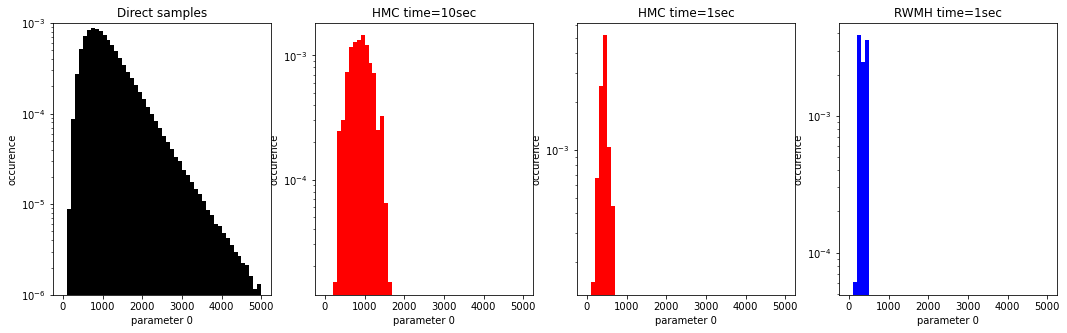

In [239]:
plt.figure(figsize=(18, 5))

parameter_to_plot = 0

plt.subplot(141)
plt.title("Direct samples")
_,bins,_ = plt.hist(
    samples[parameter_to_plot, :],
    range=[0,5000],
    bins=50,
    color="k",
    density=True,
)
plt.ylim([1e-6,1e-3])
plt.ylabel("occurence")
plt.xlabel(f"parameter {parameter_to_plot}")
plt.gca().set_yscale('log')

plt.subplot(142)
plt.title("HMC time=10sec")
plt.hist(
    samples_hmc_many_samples[parameter_to_plot, :],
    bins=bins,
    color="r",    density=True,

)
# plt.ylim([1e-6,1e-3])
plt.ylabel("occurence")
plt.xlabel(f"parameter {parameter_to_plot}")
plt.gca().set_yscale('log')

plt.subplot(143)
plt.title("HMC time=1sec")
plt.hist(samples_hmc[parameter_to_plot, :], bins=bins, color="r",    density=True,
)
# plt.ylim([1e-6,1e-3])
plt.ylabel("occurence")
plt.xlabel(f"parameter {parameter_to_plot}")
plt.gca().set_yscale('log')

plt.subplot(144)
plt.title("RWMH time=1sec")
plt.hist(samples_rwmh[parameter_to_plot, :], bins=bins,color="b",    density=True,
)
# plt.ylim([1e-6,1e-3])
plt.ylabel("occurence")
plt.xlabel(f"parameter {parameter_to_plot}")
plt.gca().set_yscale('log')




All three Markov chains seem to sample the distribution well, but there are strong differences in between how HMC and RWMH sample in limited time. The histogram for 1 second of HMC seems more jagged (roughed) around the mode (parameter 0 = 1000), but the tail towards the high parameters is comparatively better sampled than that of RWMH.